In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

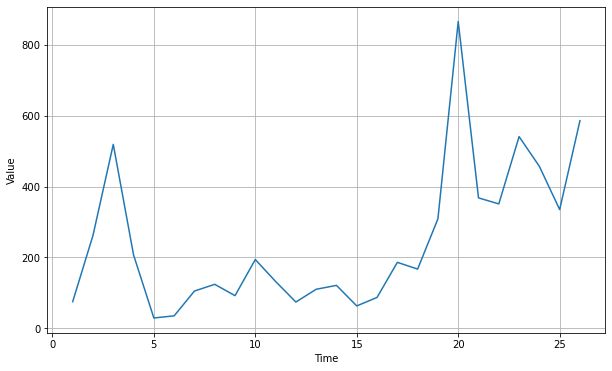

In [3]:
import csv
time_step = []
covid = []
step = 1

with open(r'../Dataset/2nd_Wave_dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        covid.append(float(row[1]))
        time_step.append(step)
        step += 1
        
series = np.array(covid)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
reshaped = series.reshape(-1,1)

In [10]:
reshaped

array([[ 75.],
       [262.],
       [519.],
       [207.],
       [ 29.],
       [ 35.],
       [105.],
       [124.],
       [ 92.],
       [194.],
       [132.],
       [ 74.],
       [110.],
       [121.],
       [ 63.],
       [ 87.],
       [186.],
       [167.],
       [309.],
       [866.],
       [368.],
       [351.],
       [541.],
       [457.],
       [335.],
       [586.]])

In [11]:
scaled_series = scaler.fit_transform(reshaped)

In [12]:
scaled_series

array([[0.05495818],
       [0.27837515],
       [0.58542413],
       [0.21266428],
       [0.        ],
       [0.00716846],
       [0.09080048],
       [0.1135006 ],
       [0.07526882],
       [0.19713262],
       [0.12305854],
       [0.05376344],
       [0.09677419],
       [0.10991637],
       [0.04062127],
       [0.0692951 ],
       [0.18757467],
       [0.16487455],
       [0.33452808],
       [1.        ],
       [0.40501792],
       [0.38470729],
       [0.61170848],
       [0.51135006],
       [0.3655914 ],
       [0.66547192]])

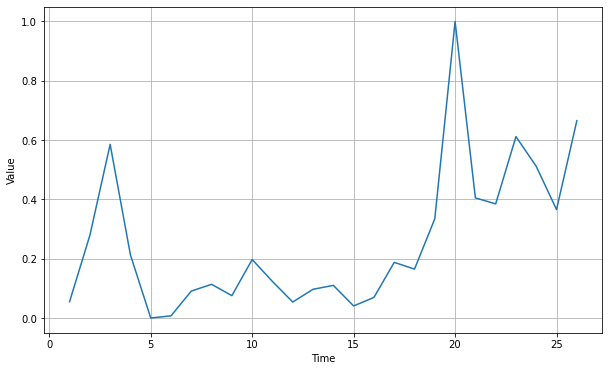

In [13]:
plt.figure(figsize = (10, 6))
plot_series(time, scaled_series)

In [15]:
split_time = 22
time_train = time[:split_time]
x_train = scaled_series[:split_time]
time_valid = time[split_time:]
x_valid = scaled_series[split_time:]

window_size = 20
batch_size = 3 ##changed from 22 to 3
shuffle_buffer_size = 20

In [16]:
def windowed_dataset(train_series, window_size, batch_size, shuffle_buffer):
    train_series = tf.expand_dims(train_series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(train_series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, train_series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(train_series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = window_size
batch_size = batch_size
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=6, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
  tf.keras.layers.Dense(20, activation="tanh"),
  #tf.keras.layers.Dropout(0),
  #tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=73, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(22, 1)
Epoch 1/73
1/1 [==============================] - 0s 5ms/step - loss: 19.4367 - mae: 19.9367
Epoch 2/73
1/1 [==============================] - 0s 904us/step - loss: 19.4270 - mae: 19.9270
Epoch 3/73
1/1 [==============================] - 0s 993us/step - loss: 19.4083 - mae: 19.9083
Epoch 4/73
1/1 [==============================] - 0s 1ms/step - loss: 19.3811 - mae: 19.8811
Epoch 5/73
1/1 [==============================] - 0s 1ms/step - loss: 19.3456 - mae: 19.8456
Epoch 6/73
1/1 [==============================] - 0s 1ms/step - loss: 19.3018 - mae: 19.8018
Epoch 7/73
1/1 [==============================] - 0s 1ms/step - loss: 19.2494 - mae: 19.7494
Epoch 8/73
1/1 [==============================] - 0s 1ms/step - loss: 19.1882 - mae: 19.6882
Epoch 9/73
1/1 [==============================] - 0s 1ms/step - loss: 19.1174 - mae: 19.6174
Epoch 10/73
1/1 [==============================] - 

(1e-08, 0.0001, 0.0, 40.0)

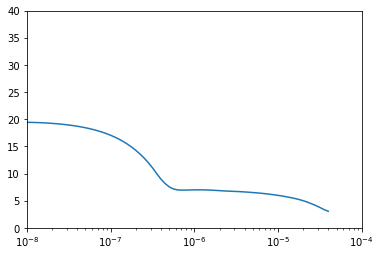

In [61]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 40])

In [62]:
rnn_forecast = model_forecast(model, scaled_series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

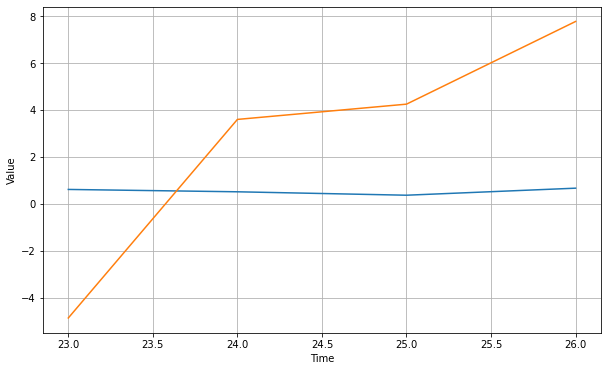

In [63]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [64]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [65]:
mae = np.mean(mae)

In [66]:
mae

4.84921